## Loading and Preparing Data 

In [5]:
import pandas as pd
import numpy as np
from copy import deepcopy 
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Trainng Samples loaded from Github Repo
ratings_path = 'https://raw.githubusercontent.com/usef-kh/EC503Project/master/Datasets/ml-1m/ratings.dat'
titles_path = 'https://raw.githubusercontent.com/usef-kh/EC503Project/master/Datasets/ml-1m/movies.dat'

ratings = pd.read_csv(ratings_path, sep  = "::", names = ['UserID', 'MovieID', 'Rating', 'Timestamp'])
titles = pd.read_csv(titles_path, sep = "::", names = ['MovieID', 'Title', 'Genres'], encoding ='latin-1')
data = pd.merge(ratings, titles, on='MovieID')

ntotal = data.shape[0]
ntrain = int(np.floor(ntotal*0.85))
ntest = ntotal - ntrain

print(f"ntotal: {ntotal}\nntrain: {ntrain}\nntest: {ntest}")

data.head()

ntotal: 1000209
ntrain: 850177
ntest: 150032


,UserID,MovieID,Rating,Timestamp,Title,Genres
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama


### Suffling dataset and splitting into test, train, and valiation

In [0]:
np.random.seed(42)
shuffled_data = data.reindex(np.random.permutation(data.index))

train = deepcopy(train_val)
val = deepcopy(train_val)

train['Rating'][ntrain:] = np.nan
val['Rating'][:ntrain] = np.nan

train_mtx = train.pivot_table(index='UserID', columns='Title', values='Rating')
test_mtx = train.pivot_table(index='UserID', columns='Title', values='Rating')

train_select = train_mtx.notnull()
test_select = test_mtx.notnull()

movie_means = np.round(2*train_mtx.mean())/2
train_mtx.fillna(movie_means, inplace = True)

train_mtx = train_mtx.values
test_mtx = test_mtx.values

train_select = train_select.values
test_select = test_select.values

## Implementing Matrix Factorization using SVD

### Tuning hyperparameters using hold out validation
#### SVD essentially performs dimention reduction through selecting the rank of the resultant matricies, specifically Sigma.

#### On a high level of understanding:
#### - U corresponds to the users' features
#### - V' captures movies' features. 

#### Obviously, the higher the rank, the more information is perserved during the reduction. However, the larger its value, the less we are learning the actual data and the more we are overfitting the training set. For this, we will be corss validating our results and minimizing the mse over a validation set to tune the value of k.

In [9]:
from scipy.sparse.linalg import svds
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error as mae

tmax = 40
MAE = []
reconstruction = train_mtx
for t in range(tmax):
  U, sigma, Vt = svds(reconstruction, 50)
  sigma = np.diag(sigma)

  reconstruction = np.round(2*(np.dot(np.dot(U, sigma), Vt)))/2
  reconstruction[~train_select] = train_mtx[~train_select]

  reconstruction[reconstruction > 5] = 5
  reconstruction[reconstruction < 0.5] = 0.5

  reconstruction = np.round(2*(np.dot(np.dot(U, sigma), Vt)))/2
  
  result = reconstruction[test_select].flatten() 
  ground_truth = test_mtx[test_select].flatten()

  cm = confusion_matrix(ground_truth*2, result*2)

  MAE.append(mae(result,ground_truth))

KeyboardInterrupt: ignored

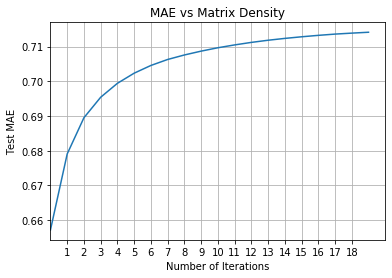

In [8]:
plt.plot(list(range(tmax)), MAE)
plt.xlabel('Number of Iterations')
plt.ylabel('Test MAE')
plt.xticks(np.arange(1, 19, 1))
plt.xlim(0,20)
plt.title("MAE vs Number of Iterations")
plt.grid()


#print("Maximum CCR:", "{0:0.2f}".format(max(CCR)) + '%', 'happens at the', CCR.index(max(CCR)), 'iteration')


## Providing Movie recommendations

In [10]:
def recommend(ground_truth, preds_df, userid, count):
  '''Return a list of top n recommended movies accoring 
     to the groud truth user ratings and our predictions'''

  # extract previous ratings and our predictions
  user_profile = ground_truth.loc[userid,:]
  user_pred = preds_df.loc[userid,:]

  # revmove movies which user has already watched and rated
  select = np.logical_not(np.multiply(user_profile, np.ones(len(user_profile))))
  movies = select.index 
  possible_recs = np.multiply(user_pred, select)
  
  # sort predicted ratings in increasing order
  user_recs = np.stack((possible_recs, movies), axis=-1) 
  user_recs = user_recs[user_recs[:,0].argsort()]

  # extract top n predicted ratings and recommend their movies
  user_recs = user_recs[-count:,1]
  user_recs = np.flip(user_recs)

  return user_recs

# extract 5 recommendations for the first user
recs = recommend(ground_truth, preds_df, 1, 5)
print(recs)
print(recs[0])

NameError: ignored

In [0]:
# # SVD algorithm.
# !pip install scikit-surprise
# from surprise import Dataset

# from surprise import SVD
# from surprise.model_selection import cross_validate

# algo = SVD()
# data = Dataset.load_builtin('ml-1m')
# cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
